<br>
<left><bold><font size="5"> Artificial Intelligence Tool for Churn Prediction Model and Customer Segmentation using Unsupervised Learning</font></bold></left>
<br>
<br>


In [1]:
# Import pyspark
import pyspark
from pyspark import SparkConf
from pyspark.ml.feature import (
    StringIndexer,
    OneHotEncoder,
    VectorAssembler,
    StandardScaler,
)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, ClusteringEvaluator

from pyspark.sql.types import FloatType, StringType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

# Import numpy, pandas, matpoltlib, seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn import metrics

# import xgboost
import xgboost as xgb

# Import keras
import keras
from keras import Sequential, regularizers
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import np_utils

sns.set_style("whitegrid")  # Set style of seaborn


Using TensorFlow backend.
C:\Users\Dell\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Dell\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Dell\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [2]:
# Create SparkSession in local environment
spark = (
    SparkSession.builder.appName("Telecom_Churn")  # create a name
    .config("spark.executor.memory", "10g")  # Maximum amount of memory allowed
    .config("spark.executor.cores", "3")  # Maximum cpu threads allowed
    .config("spark.cores.max", "3")
    .config("spark.driver.memory", "10g")
    .config("spark.sql.broadcastTimeout", "9000")
    .getOrCreate()
)
SparkConf().getAll()


C:\Users\Dell\AppData\Local\Programs\Python\Python37\lib\site-packages\pyspark\context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


[('spark.app.name', 'Telecom_Churn'),
 ('spark.sql.broadcastTimeout', '9000'),
 ('spark.executor.memory', '10g'),
 ('spark.driver.memory', '10g'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.cores', '3'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.submitTime', '1691671078494'),
 ('spark.cores.max', '3')]

In [3]:
# Define a load founction
def load(path, show_num=None, printable=True):
    """
    read csv file, drop null values, print the length of the rows
    """
    data = spark.read.csv(path, header="true", inferSchema=True)
    data = data.na.drop()
    if show_num:
        data.show(show_num)

    if printable == True:
        data.printSchema()
        print("Length:", data.count())
    return data


In [4]:
# Define the path of data source and load into spark dataframe
path = "cell2celltrain.csv"
df = load(path)
df.select("MonthlyRevenue").describe().show()


root
 |-- CustomerID: integer (nullable = true)
 |-- Churn: string (nullable = true)
 |-- MonthlyRevenue: string (nullable = true)
 |-- MonthlyMinutes: string (nullable = true)
 |-- TotalRecurringCharge: string (nullable = true)
 |-- DirectorAssistedCalls: string (nullable = true)
 |-- OverageMinutes: string (nullable = true)
 |-- RoamingCalls: string (nullable = true)
 |-- PercChangeMinutes: string (nullable = true)
 |-- PercChangeRevenues: string (nullable = true)
 |-- DroppedCalls: double (nullable = true)
 |-- BlockedCalls: double (nullable = true)
 |-- UnansweredCalls: double (nullable = true)
 |-- CustomerCareCalls: double (nullable = true)
 |-- ThreewayCalls: double (nullable = true)
 |-- ReceivedCalls: double (nullable = true)
 |-- OutboundCalls: double (nullable = true)
 |-- InboundCalls: double (nullable = true)
 |-- PeakCallsInOut: double (nullable = true)
 |-- OffPeakCallsInOut: double (nullable = true)
 |-- DroppedBlockedCalls: double (nullable = true)
 |-- CallForwardingC

In [5]:
# Delete the rows with 'NA' values
for column in df.columns:
    if df.schema[column].dataType == pyspark.sql.types.StringType():
        df = df.filter(df[column] != "NA")


In [6]:
# Check the description of Churn column
df.select("Churn").describe().show()


+-------+-----+
|summary|Churn|
+-------+-----+
|  count|49752|
|   mean| null|
| stddev| null|
|    min|   No|
|    max|  Yes|
+-------+-----+



In [7]:
# Going through all columns required to be transfer into numerical values
columns_string = [
    column
    for column in df.columns
    if df.schema[column].dataType == pyspark.sql.types.StringType()
]
columns_string


['Churn',
 'MonthlyRevenue',
 'MonthlyMinutes',
 'TotalRecurringCharge',
 'DirectorAssistedCalls',
 'OverageMinutes',
 'RoamingCalls',
 'PercChangeMinutes',
 'PercChangeRevenues',
 'ServiceArea',
 'Handsets',
 'HandsetModels',
 'CurrentEquipmentDays',
 'AgeHH1',
 'AgeHH2',
 'ChildrenInHH',
 'HandsetRefurbished',
 'HandsetWebCapable',
 'TruckOwner',
 'RVOwner',
 'Homeownership',
 'BuysViaMailOrder',
 'RespondsToMailOffers',
 'OptOutMailings',
 'NonUSTravel',
 'OwnsComputer',
 'HasCreditCard',
 'NewCellphoneUser',
 'NotNewCellphoneUser',
 'OwnsMotorcycle',
 'HandsetPrice',
 'MadeCallToRetentionTeam',
 'CreditRating',
 'PrizmCode',
 'Occupation',
 'MaritalStatus']

In [8]:
# create the view of df under spark
df.createOrReplaceTempView("df")

# check the distribution of picked columns
spark.sql(
    "SELECT \
            Churn, \
            CAST (avg(MonthlyRevenue) as decimal(8,2)) as avg_MonthlyRevenue, \
            CAST (avg(MonthlyMinutes) as decimal(8,2)) as avg_MonthlyMinutes, \
            CAST (avg(CurrentEquipmentDays) as decimal(8,2)) as avg_CurrentEquipmentDays, \
            CAST (avg(TotalRecurringCharge) as decimal(8,2)) as avg_TotalRecurringCharge, \
            CAST (avg(OverageMinutes) as decimal(8,2)) as avg_OverageMinutes, \
            CAST (avg(RoamingCalls) as decimal(8,2)) as avg_RoamingCalls \
            FROM df GROUP BY Churn"
).show()


+-----+------------------+------------------+------------------------+------------------------+------------------+----------------+
|Churn|avg_MonthlyRevenue|avg_MonthlyMinutes|avg_CurrentEquipmentDays|avg_TotalRecurringCharge|avg_OverageMinutes|avg_RoamingCalls|
+-----+------------------+------------------+------------------------+------------------------+------------------+----------------+
|   No|             59.06|            541.81|                  363.64|                   47.72|             38.82|            1.16|
|  Yes|             57.87|            483.16|                  420.85|                   44.62|             42.08|            1.40|
+-----+------------------+------------------+------------------------+------------------------+------------------+----------------+



In [9]:
# Check the values of string columns
df.select([column for column in df.columns if column in columns_string]).show(1)


+-----+--------------+--------------+--------------------+---------------------+--------------+------------+-----------------+------------------+-----------+--------+-------------+--------------------+------+------+------------+------------------+-----------------+----------+-------+-------------+----------------+--------------------+--------------+-----------+------------+-------------+----------------+-------------------+--------------+------------+-----------------------+------------+---------+------------+-------------+
|Churn|MonthlyRevenue|MonthlyMinutes|TotalRecurringCharge|DirectorAssistedCalls|OverageMinutes|RoamingCalls|PercChangeMinutes|PercChangeRevenues|ServiceArea|Handsets|HandsetModels|CurrentEquipmentDays|AgeHH1|AgeHH2|ChildrenInHH|HandsetRefurbished|HandsetWebCapable|TruckOwner|RVOwner|Homeownership|BuysViaMailOrder|RespondsToMailOffers|OptOutMailings|NonUSTravel|OwnsComputer|HasCreditCard|NewCellphoneUser|NotNewCellphoneUser|OwnsMotorcycle|HandsetPrice|MadeCallToReten

In [10]:
# Based on the values of the string columns, select the list of columns for StringIndexer
columns_for_indexer = [
    "Churn",
    "ChildrenInHH",
    "HandsetRefurbished",
    "HandsetWebCapable",
    "TruckOwner",
    "RVOwner",
    "Homeownership",
    "BuysViaMailOrder",
    "RespondsToMailOffers",
    "OptOutMailings",
    "NonUSTravel",
    "OwnsComputer",
    "HasCreditCard",
    "NewCellphoneUser",
    "NotNewCellphoneUser",
    "OwnsMotorcycle",
    "MadeCallToRetentionTeam",
    "MaritalStatus",
]


In [11]:
# Loop the list and use StringIndexer encodes the string columns of labels(Yes or No) to columns of label indices(1 or 0)
for column in columns_for_indexer:
    indexer = StringIndexer(inputCol=column, outputCol=column + "Index")
    df = indexer.fit(df).transform(df)


In [12]:
# Drop the original string columns of labels
df = df.select([column for column in df.columns if column not in columns_for_indexer])


In [13]:
# Check the Churn column again to confirm the result
df.select("ChurnIndex").describe().show()


+-------+-------------------+
|summary|         ChurnIndex|
+-------+-------------------+
|  count|              49752|
|   mean|0.28632014793375143|
| stddev|0.45204538278095524|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



In [14]:
# Replace unknown values to 0 for Price Column
df = df.replace(to_replace={"Unknown": "0"}, subset=["HandsetPrice"])


In [15]:
# Delete the rows with 'NA' values
for column in df.columns:
    if df.schema[column].dataType == pyspark.sql.types.StringType():
        df = df.filter(df[column] != "Unknown")


In [16]:
# Another Iteration for feature engineering
columns_string = [
    column
    for column in df.columns
    if df.schema[column].dataType == pyspark.sql.types.StringType()
]
columns_string


['MonthlyRevenue',
 'MonthlyMinutes',
 'TotalRecurringCharge',
 'DirectorAssistedCalls',
 'OverageMinutes',
 'RoamingCalls',
 'PercChangeMinutes',
 'PercChangeRevenues',
 'ServiceArea',
 'Handsets',
 'HandsetModels',
 'CurrentEquipmentDays',
 'AgeHH1',
 'AgeHH2',
 'HandsetPrice',
 'CreditRating',
 'PrizmCode',
 'Occupation']

In [17]:
# Mapping string values into integer based on its values
mapping_PrizmCode = {"Other": "0", "Suburban": "1", "Town": "2", "Rural": "3"}
df = df.replace(to_replace=mapping_PrizmCode, subset=["PrizmCode"])


In [18]:
# Prepare the list of columns to be transformed into float
columns_to_float = [
    "MonthlyRevenue",
    "MonthlyMinutes",
    "TotalRecurringCharge",
    "DirectorAssistedCalls",
    "OverageMinutes",
    "RoamingCalls",
    "PercChangeMinutes",
    "PercChangeRevenues",
]


In [19]:
# Transform ServiceArea and CreditRating columns only to keep the int value
df = df.withColumn("ServiceArea", df["ServiceArea"].substr(-3, 3))
df = df.withColumn("CreditRating", df["CreditRating"].substr(1, 1))


In [20]:
# Transform the type of columns to float
for column in columns_to_float:
    df = df.withColumn(column, df[column].cast("float"))


In [21]:
# Create a Pandas DataFrame for data visualization
df_pd = df.toPandas()


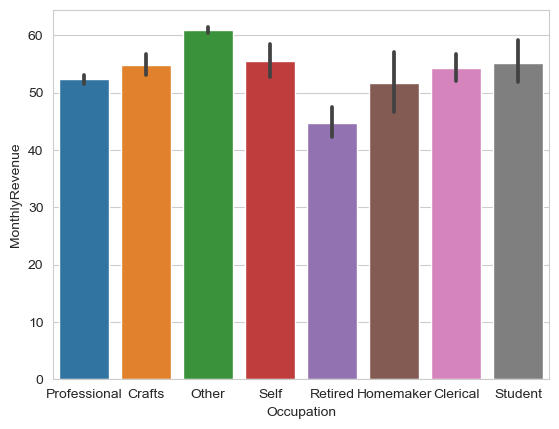

In [22]:
# Before transform the type of Occupation column, let's check it's distribution first
graph = df_pd[["Occupation", "MonthlyRevenue"]]
ax = sns.barplot(x="Occupation", y="MonthlyRevenue", data=graph)


In [23]:
# Transform string values to numbers using mapping
temp = (
    df_pd.loc[:, ["Occupation", "MonthlyRevenue"]]
    .groupby("Occupation")
    .mean()
    .sort_values(["MonthlyRevenue"], ascending=[0])
)

mapping_Occupation = dict([temp.index[i], str(i)] for i in range(len(temp)))
print(mapping_Occupation)

df = df.replace(to_replace=mapping_Occupation, subset=["Occupation"])


{'Other': '0', 'Self': '1', 'Student': '2', 'Crafts': '3', 'Clerical': '4', 'Professional': '5', 'Homemaker': '6', 'Retired': '7'}


In [24]:
df.describe()


DataFrame[summary: string, CustomerID: string, MonthlyRevenue: string, MonthlyMinutes: string, TotalRecurringCharge: string, DirectorAssistedCalls: string, OverageMinutes: string, RoamingCalls: string, PercChangeMinutes: string, PercChangeRevenues: string, DroppedCalls: string, BlockedCalls: string, UnansweredCalls: string, CustomerCareCalls: string, ThreewayCalls: string, ReceivedCalls: string, OutboundCalls: string, InboundCalls: string, PeakCallsInOut: string, OffPeakCallsInOut: string, DroppedBlockedCalls: string, CallForwardingCalls: string, CallWaitingCalls: string, MonthsInService: string, UniqueSubs: string, ActiveSubs: string, ServiceArea: string, Handsets: string, HandsetModels: string, CurrentEquipmentDays: string, AgeHH1: string, AgeHH2: string, RetentionCalls: string, RetentionOffersAccepted: string, ReferralsMadeBySubscriber: string, IncomeGroup: string, AdjustmentsToCreditRating: string, HandsetPrice: string, CreditRating: string, PrizmCode: string, Occupation: string, C

In [25]:
# Prepare the list of columns to be transformed into integer
columns_to_int = [
    "Handsets",
    "HandsetModels",
    "CurrentEquipmentDays",
    "AgeHH1",
    "AgeHH2",
    "HandsetPrice",
    "ServiceArea",
    "CreditRating",
    "PrizmCode",
    "Occupation",
    "ChurnIndex",
    "ChildrenInHHIndex",
    "HandsetRefurbishedIndex",
    "HandsetWebCapableIndex",
    "TruckOwnerIndex",
    "RVOwnerIndex",
    "HomeownershipIndex",
    "BuysViaMailOrderIndex",
    "RespondsToMailOffersIndex",
    "OptOutMailingsIndex",
    "NonUSTravelIndex",
    "OwnsComputerIndex",
    "HasCreditCardIndex",
    "NewCellphoneUserIndex",
    "NotNewCellphoneUserIndex",
    "OwnsMotorcycleIndex",
    "MadeCallToRetentionTeamIndex",
    "MaritalStatusIndex",
]


In [26]:
# Transform the type of columns to integer
for column in columns_to_int:
    df = df.withColumn(column, df[column].cast("int"))


## Analysis & Visualization <a name="Analysis&Visualization"></a>

In [27]:
# Go through the dataset check the distribution of each feature
for i in range(len(df.columns) // 6 + 1):
    df.describe(df.columns[6 * i : 6 * (i + 1)]).show()


+-------+------------------+-----------------+-----------------+--------------------+---------------------+-----------------+
|summary|        CustomerID|   MonthlyRevenue|   MonthlyMinutes|TotalRecurringCharge|DirectorAssistedCalls|   OverageMinutes|
+-------+------------------+-----------------+-----------------+--------------------+---------------------+-----------------+
|  count|             49752|            49752|            49752|               49752|                49752|            49752|
|   mean|  3200957.68290722|58.71737385609968|525.0214664737096|   46.83496140858659|   0.8918407307885328|39.75404003859141|
| stddev|116469.39654595919|44.31724378172586|528.5101549841828|   23.75949230234842|   2.2247253274787284|96.09160595755414|
|    min|           3000002|            -6.17|              0.0|                -6.0|                  0.0|              0.0|
|    max|           3399974|          1223.38|           7359.0|               400.0|               159.39|           

+-------+-------------------------+-------------------+-------------------+-------------------+------------------+---------------------+
|summary|RespondsToMailOffersIndex|OptOutMailingsIndex|   NonUSTravelIndex|  OwnsComputerIndex|HasCreditCardIndex|NewCellphoneUserIndex|
+-------+-------------------------+-------------------+-------------------+-------------------+------------------+---------------------+
|  count|                    49752|              49752|              49752|              49752|             49752|                49752|
|   mean|      0.38360266923942754| 0.0149943720855443|0.05740472744814279|0.18861553304389772|0.3117663611513105|  0.19317816369191187|
| stddev|       0.4862678419281868|0.12153122134057223| 0.2326166638904297| 0.3912068376853649|0.4632196131919155|   0.3947955085523836|
|    min|                        0|                  0|                  0|                  0|                 0|                    0|
|    max|                        1|      

In [28]:
# Create a new Pandas DataFrame for data visualization
df_pd = df.toPandas()


In [29]:
# Define Catplot function and Barplot function
def cat_plot(feature, cut=12):
    temp = df_pd.loc[:, [feature, "ChurnIndex"]]
    temp[feature + "_binned"] = pd.qcut(temp[feature], cut, duplicates="drop")
    ax = sns.catplot(
        x="ChurnIndex",
        y=feature + "_binned",
        data=temp,
        kind="bar",
        height=5,
        aspect=2.7,
    )


def bar_plot(feature, cut=False, logscale=False, drop_zero=False):
    if drop_zero:
        temp = df_pd[df_pd[feature] != 0].loc[:, [feature, "ChurnIndex"]]
    else:
        temp = df_pd.loc[:, [feature, "ChurnIndex"]]

    if cut > 0:
        temp[feature + "_binned"] = pd.qcut(temp[feature], cut, duplicates="drop")
        ax = sns.barplot(x=feature + "_binned", y="ChurnIndex", data=temp)
    else:
        ax = sns.barplot(x=feature, y="ChurnIndex", data=temp)

    if logscale:
        ax.set_yscale("log")


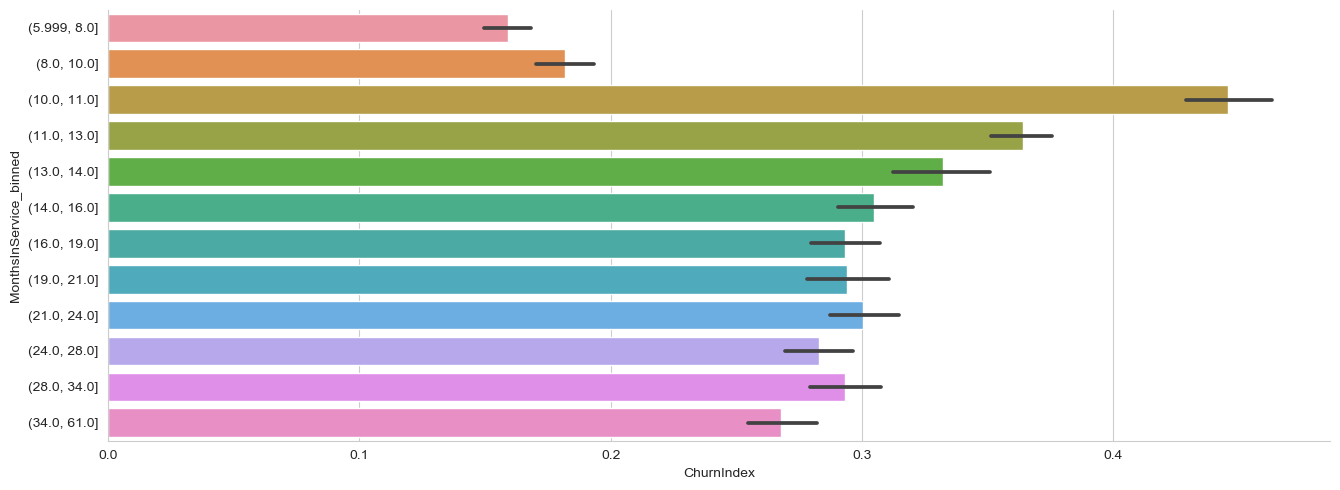

In [30]:
# Use defined Catplot function plot the distribution of MonthsInService
cat_plot("MonthsInService", cut=12)


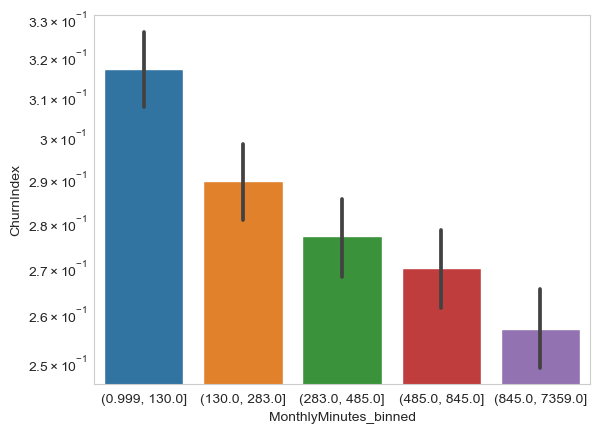

In [31]:
# Use defined Barplot function plot the distribution of MonthlyMinutes
bar_plot("MonthlyMinutes", cut=5, logscale=True, drop_zero=True)


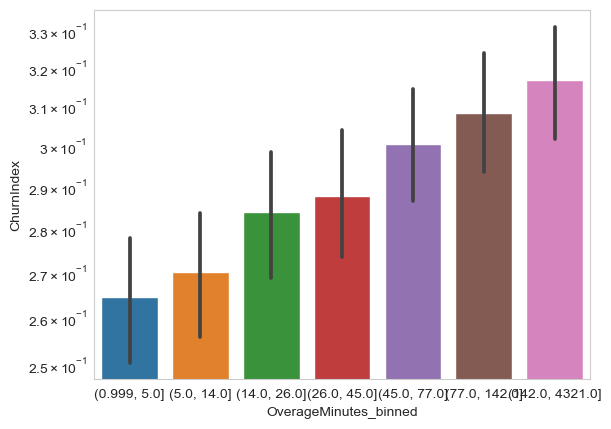

In [32]:
# Use defined Barplot function plot the distribution of OverageMinutes
bar_plot("OverageMinutes", cut=7, logscale=True, drop_zero=True)


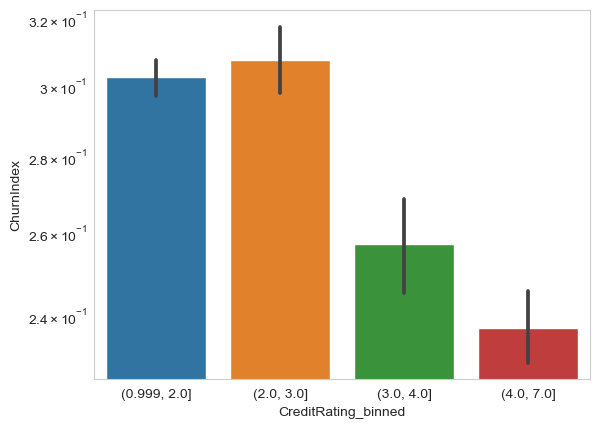

In [33]:
# Use defined Barplot function plot the distribution of CreditRating
bar_plot("CreditRating", cut=5, logscale=True)


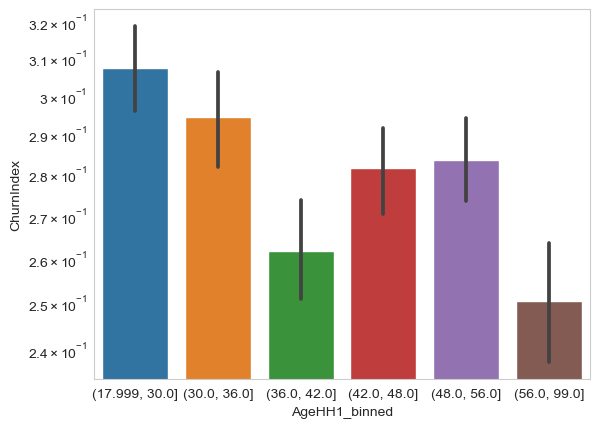

In [34]:
# Use defined Barplot function plot the distribution of AgeHH1
bar_plot("AgeHH1", cut=6, logscale=True, drop_zero=True)


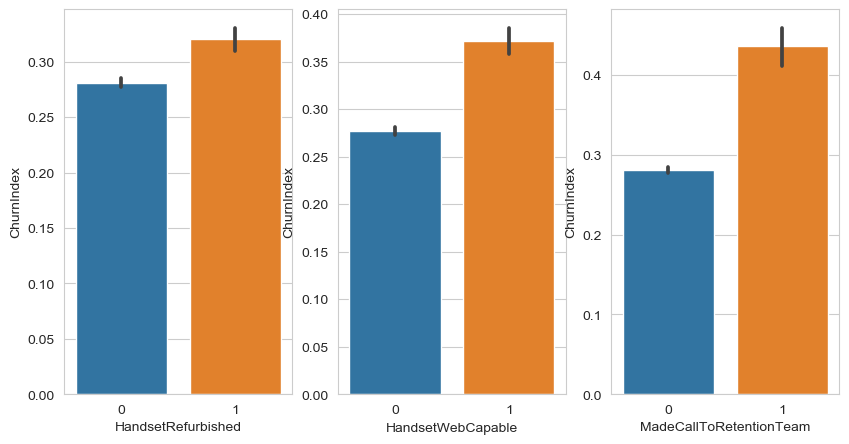

In [35]:
# Subplots the distribution of HandsetRefurbished, HandsetWebCapable and MadeCallToRetentionTeam into one graph
feature = [
    "HandsetRefurbishedIndex",
    "HandsetWebCapableIndex",
    "MadeCallToRetentionTeamIndex",
    "ChurnIndex",
]
temp = df_pd.loc[:, feature]
temp.columns = [
    "HandsetRefurbished",
    "HandsetWebCapable",
    "MadeCallToRetentionTeam",
    "ChurnIndex",
]

fig, axs = plt.subplots(figsize=(10, 5), ncols=3)
sns.barplot(x="HandsetRefurbished", y="ChurnIndex", data=temp, ax=axs[0])
sns.barplot(x="HandsetWebCapable", y="ChurnIndex", data=temp, ax=axs[1])
sns.barplot(x="MadeCallToRetentionTeam", y="ChurnIndex", data=temp, ax=axs[2])


## Prediction Model Training and Evaluation <a name="Modeling"></a>

### Data Preprocessing

In [36]:
# Create column list for VectorAssembler
inputcols = [
    column for column in df.columns if column not in ["CustomerID", "ChurnIndex"]
]


In [37]:
# Use vectorAssembler transform the given list of columns into a single vector column.
vectorAssembler = VectorAssembler(inputCols=inputcols, outputCol="features")
features_vectorized = vectorAssembler.transform(df)
features_vectorized = features_vectorized.withColumnRenamed("ChurnIndex", "label")


In [38]:
# StandardScaler
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(features_vectorized)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(features_vectorized)
scaledData.show()


+----------+--------------+--------------+--------------------+---------------------+--------------+------------+-----------------+------------------+------------+------------+---------------+-----------------+-------------+-------------+-------------+------------+--------------+-----------------+-------------------+-------------------+----------------+---------------+----------+----------+-----------+--------+-------------+--------------------+------+------+--------------+-----------------------+-------------------------+-----------+-------------------------+------------+------------+---------+----------+-----+-----------------+-----------------------+----------------------+---------------+------------+------------------+---------------------+-------------------------+-------------------+----------------+-----------------+------------------+---------------------+------------------------+-------------------+----------------------------+------------------+--------------------+----------

In [39]:
# Check the distribution of label
scaledData.select("label").groupBy("label").count().collect()


[Row(label=1, count=14245), Row(label=0, count=35507)]

Since the data set is highly skewed – we have much more Negative training samples than Positive training samples – we will need to try out some strategies that counter the unbalance.

Here I'm going to use one of the simplest method called down-samplings, which means we just randomly filter out some of the majority cases.

In [40]:
# Down-sampling  
from pyspark.sql import functions as F  # Import necessary functions if using PySpark

scaledData_ds = scaledData.filter(scaledData["label"] == 0.0).randomSplit([0.4, 0.6])[0]
scaledData_ds = scaledData.filter(scaledData["label"] == 1.0).union(scaledData_ds)
scaledData_ds.select("label").groupBy("label").count().show()


+-----+-----+
|label|count|
+-----+-----+
|    1|14245|
|    0|14257|
+-----+-----+



In [41]:
# Split dataset into train and test set
train, test = scaledData_ds.randomSplit([0.8, 0.2])


In [42]:
# Define plot roc curve function
def plot_roc_curve(model, train, test):
    predictions = model.transform(test)
    predictions_train = model.transform(train)

    results = predictions.select(["probability", "label"])
    results_train = predictions_train.select(["probability", "label"])

    ## prepare score-label set
    results_collect = results.collect()
    results_list = [(float(i[0][0]), 1.0 - float(i[1])) for i in results_collect]

    results_collect_train = results_train.collect()
    results_list_train = [
        (float(i[0][0]), 1.0 - float(i[1])) for i in results_collect_train
    ]

    fpr = dict()
    fpr_train = dict()
    tpr = dict()
    tpr_train = dict()
    roc_auc = dict()
    roc_auc_train = dict()

    y_test = [i[1] for i in results_list]
    y_score = [i[0] for i in results_list]

    y_train = [i[1] for i in results_list_train]
    y_score_train = [i[0] for i in results_list_train]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    roc_auc_train = auc(fpr_train, tpr_train)

    plt.figure()
    plt.plot(fpr, tpr, label="ROC curve on testing set (area = %0.2f)" % roc_auc)
    plt.plot(
        fpr_train,
        tpr_train,
        label="ROC curve on training set (area = %0.2f)" % roc_auc_train,
    )
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()


### Random Forest Classifier

In [43]:
# Validation for hyper-parameter tuning.
# Randomly splits the input dataset into train and validation sets,
# and uses evaluation metric on the validation set to select the best model.
rf = RandomForestClassifier(
    featuresCol="features", labelCol="label", predictionCol="prediction", maxBins=16
)

# Use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using the evaluator.
paramGrid = (
    ParamGridBuilder()
    .addGrid(rf.maxDepth, [8, 10, 12])
    .addGrid(rf.minInstancesPerNode, [1, 3, 5, 10])
    .addGrid(rf.numTrees, [50, 100])
    .build()
)

# In this case the estimator is BinaryClassificationEvaluator
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=BinaryClassificationEvaluator(),
    trainRatio=0.8,
)  # 80% of the data will be used for training, 20% for validation.

# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train)


In [44]:
# From the best model take chosen hyper-parameters 
best_model = model.bestModel.extractParamMap()

for key in best_model.keys():
    print(str(key).split("_")[-1], ":", best_model[key])


bootstrap : True
cacheNodeIds : False
checkpointInterval : 10
featureSubsetStrategy : auto
featuresCol : features
impurity : gini
labelCol : label
leafCol : 
maxBins : 16
maxDepth : 12
maxMemoryInMB : 256
minInfoGain : 0.0
minInstancesPerNode : 10
minWeightFractionPerNode : 0.0
numTrees : 100
predictionCol : prediction
probabilityCol : probability
rawPredictionCol : rawPrediction
seed : 7078489005825802278
subsamplingRate : 1.0


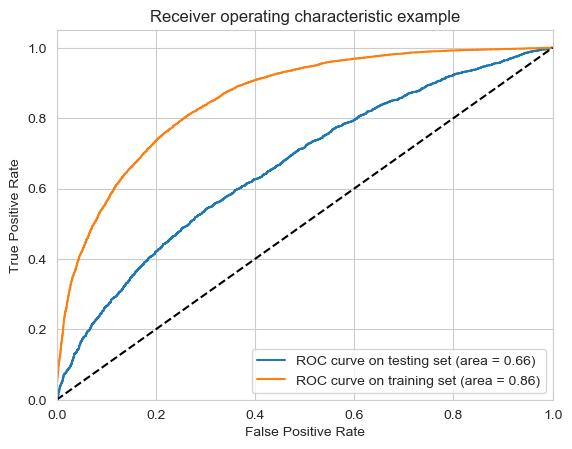

In [45]:
# Use defined function plot roc curve and print roc auc score
plot_roc_curve(model, train, test)


Text(0.5, 9.444444444444438, 'Feature Importance')

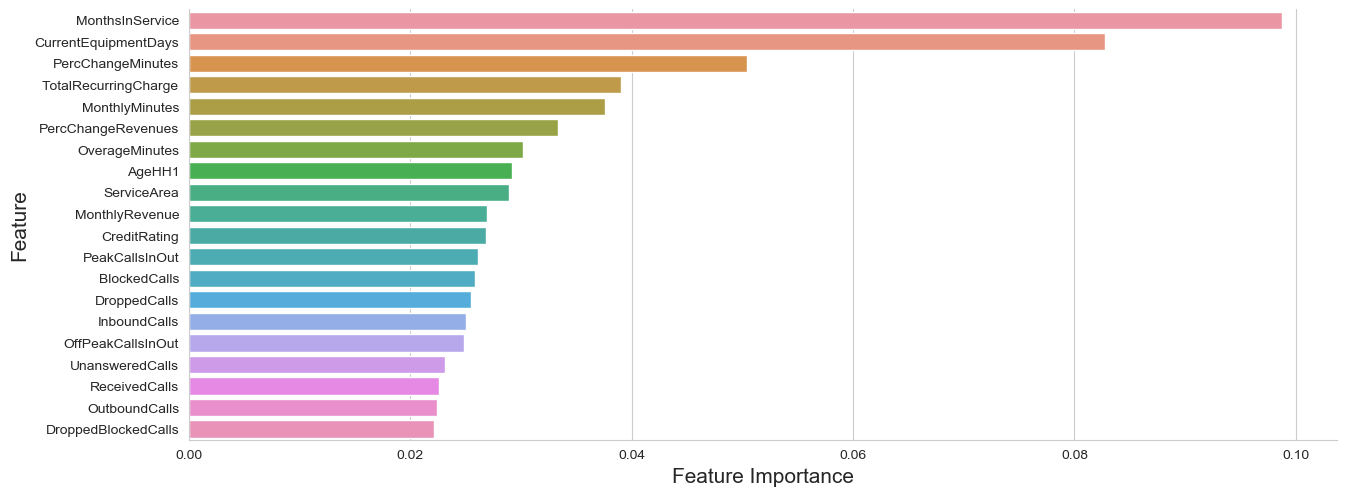

In [46]:
# Evaluate the feature importances and plot the charts for most important 20 features
importance = model.bestModel.featureImportances
features_list = inputcols
feature_importance = pd.DataFrame(
    data={"features_list": features_list, "importance": importance}
)
feature_importance = feature_importance.sort_values(by="importance", ascending=False)[
    :20
]
sns.catplot(
    x="importance",
    y="features_list",
    data=feature_importance,
    kind="bar",
    height=5,
    aspect=2.7,
)
plt.ylabel("Feature", fontsize=15)
plt.xlabel("Feature Importance", fontsize=15)


### Gradient-Boosted Trees(GBTs) Classifier

In [47]:
# Validation for hyper-parameter tuning.
# Randomly splits the input dataset into train and validation sets,
# and uses evaluation metric on the validation set to select the best model.
gbt = GBTClassifier(
    featuresCol="features", labelCol="label", predictionCol="prediction"
)

# Use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using the evaluator.
paramGrid = (
    ParamGridBuilder()
    .addGrid(gbt.maxDepth, [8, 10])
    .addGrid(gbt.minInstancesPerNode, [5, 20, 50])
    .addGrid(gbt.maxIter, [10, 20])
    .build()
)

# In this case the estimator is BinaryClassificationEvaluator
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(
    estimator=gbt,
    estimatorParamMaps=paramGrid,
    evaluator=BinaryClassificationEvaluator(),
    trainRatio=0.8,
)  # 80% of the data will be used for training, 20% for validation.

# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train)

# Make predictions on test data. model is the model with combination of parameters that performed best.
model.transform(test).select("features", "label", "prediction").show(10)


+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(56,[0,1,2,4,6,7,...|    1|       1.0|
|(56,[0,1,2,6,7,10...|    1|       0.0|
|(56,[0,1,2,5,7,8,...|    1|       1.0|
|(56,[0,1,2,3,4,6,...|    1|       0.0|
|[117.120002746582...|    1|       1.0|
|(56,[0,1,2,5,6,7,...|    1|       0.0|
|[63.2999992370605...|    1|       1.0|
|(56,[0,1,2,4,6,7,...|    1|       1.0|
|(56,[0,1,2,3,6,7,...|    1|       0.0|
|(56,[0,1,2,6,7,8,...|    1|       0.0|
+--------------------+-----+----------+
only showing top 10 rows



In [48]:
# From the best model take chosen hyper-parameters 
best_model = model.bestModel.extractParamMap()

for key in best_model.keys():
    print(str(key).split("_")[-1], ":", best_model[key])


cacheNodeIds : False
checkpointInterval : 10
featureSubsetStrategy : all
featuresCol : features
impurity : variance
labelCol : label
leafCol : 
lossType : logistic
maxBins : 32
maxDepth : 10
maxIter : 20
maxMemoryInMB : 256
minInfoGain : 0.0
minInstancesPerNode : 50
minWeightFractionPerNode : 0.0
predictionCol : prediction
probabilityCol : probability
rawPredictionCol : rawPrediction
seed : 6867085509179125946
stepSize : 0.1
subsamplingRate : 1.0
validationTol : 0.01


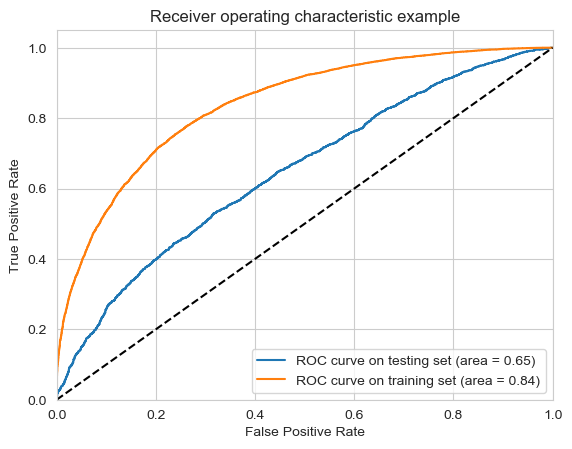

In [49]:
# Use defined function plot roc curve and print roc auc score
plot_roc_curve(model, train, test)


### Use XGBoost Regressor Algorithm Build Revenue Loss Prediction Model

In [50]:
# Transofrm scaledData into pandas Dataframe so we can use XGBoost and Keras
dataset = scaledData.toPandas()

# Create revenue loss column as label
dataset["revenue_loss"] = dataset.label * dataset.MonthlyRevenue

# Create the list of features
feature_list = [
    column
    for column in dataset.columns
    if column
    not in ["CustomerID", "label", "features", "revenue_loss", "scaledFeatures"]
]

# Create X, y, and split into train/test sets
X = dataset.loc[:, feature_list]
y = dataset.revenue_loss
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [51]:
# Use GridSearch method to figure the best hyper-parameters
# Parameters to search over with cross-validation
grid_params = [
    {
        "max_depth": [4, 5],
        "learning_rate": [0.1, 1],
        "n_estimators": [10, 100],
        "reg_lambda": [100, 10],
        "objective": ["reg:linear"],
    }
]

xgbr = GridSearchCV(xgb.XGBRegressor(), grid_params, cv=5, scoring="r2")
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

print("Mean Absolute Error: %r\n" % metrics.mean_absolute_error(y_test, y_pred))
print("Best parameter values: %r\n" % xgbr.best_params_)


[18:45:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:45:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:45:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:45:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:45:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:45:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[18:47:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:47:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:47:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:47:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:47:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[18:47:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

Highest Risk Group(5.00% of total clients) can capture 16.73% of total revenue_loss


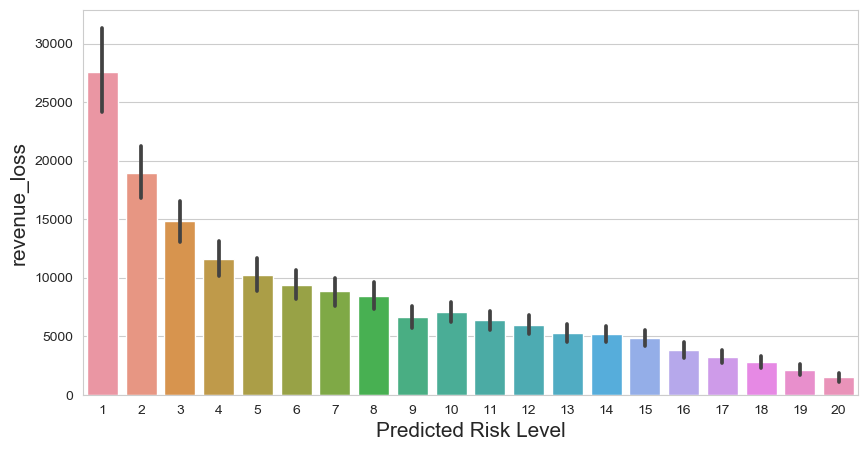

In [52]:
# Plot a chart of how many of total revenue loss can be captured with our predicted highest risk group
temp = X_test.copy()
temp["revenue_loss"] = y_test
temp["y_pred"] = y_pred
n = 20
temp["y_pred_bin"] = pd.qcut(temp["y_pred"], n, duplicates="drop")
l = len(temp["y_pred_bin"].unique())
labels = [l + 1 - i for i in range(1, l + 1)]
temp["y_pred_bin"] = pd.qcut(temp["y_pred"], n, labels=labels, duplicates="drop")
index_amount = temp.index[(temp.y_pred_bin == 1)]
fig = plt.figure(figsize=(10, 5))
labels.sort()
ax = sns.barplot(
    x="y_pred_bin", y="revenue_loss", data=temp, estimator=np.sum, order=labels
)
plt.xlabel("Predicted Risk Level", fontsize=15)
plt.ylabel("revenue_loss", fontsize=15)
per = 100 * sum(temp.y_pred_bin == 1) / len(temp.y_pred_bin)
print(
    "Highest Risk Group(%.2f%% of total clients) can capture %.2f%% of total revenue_loss"
    % (
        per,
        100 * temp[(temp.y_pred_bin == 1)].revenue_loss.sum() / temp.revenue_loss.sum(),
    )
)


### Use Keras deploy Nural networks to predict revenue loss

In [53]:
a = 0.0005
drop = 0.2
n = X_train.shape[1]

model = Sequential(
    [
        Dense(
            int(n * 1.2),
            input_dim=n,
            kernel_regularizer=regularizers.l1_l2(l1=a, l2=a),
            activation="relu",
        ),
        Dropout(drop),
        Dense(
            int(n), kernel_regularizer=regularizers.l1_l2(l1=a, l2=a), activation="relu"
        ),
        Dropout(drop),
        Dense(
            int(n * 0.8),
            activation="relu",
            kernel_regularizer=regularizers.l1_l2(l1=a, l2=a),
        ),
        Dense(1),
    ]
)


In [54]:
# Prints a summary representation of model
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 67)                3819      
_________________________________________________________________
dropout_1 (Dropout)          (None, 67)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 56)                3808      
_________________________________________________________________
dropout_2 (Dropout)          (None, 56)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 44)                2508      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 45        
Total params: 10,180
Trainable params: 10,180
Non-trainable params: 0
__________________________________________________

In [55]:
# Configures the model for training and fit the training set
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae", "accuracy"])
history = model.fit(
    X_train, y_train, validation_split=0.2, epochs=5, verbose=1, shuffle=True
)



Train on 31840 samples, validate on 7961 samples
Epoch 1/5
31840/31840 [==============================] - 9s 278us/step - loss: 1355.8415 - mae: 24.2618 - accuracy: 0.0077 - val_loss: 1268.4009 - val_mae: 21.4050 - val_accuracy: 2.5122e-04
Epoch 2/5
31840/31840 [==============================] - 8s 255us/step - loss: 1171.6672 - mae: 23.0626 - accuracy: 9.7362e-04 - val_loss: 1288.2793 - val_mae: 20.9137 - val_accuracy: 1.2561e-04
Epoch 3/5
31840/31840 [==============================] - 8s 245us/step - loss: 1142.4085 - mae: 22.9346 - accuracy: 4.7111e-04 - val_loss: 1205.1438 - val_mae: 22.2133 - val_accuracy: 2.5122e-04
Epoch 4/5
31840/31840 [==============================] - 8s 241us/step - loss: 1133.3604 - mae: 23.0153 - accuracy: 5.0251e-04 - val_loss: 1211.7138 - val_mae: 21.2056 - val_accuracy: 0.0000e+00
Epoch 5/5
31840/31840 [==============================] - 8s 249us/step - loss: 1122.9582 - mae: 22.8933 - accuracy: 3.1407e-04 - val_loss: 1212.9545 - val_mae: 21.7981 - val_

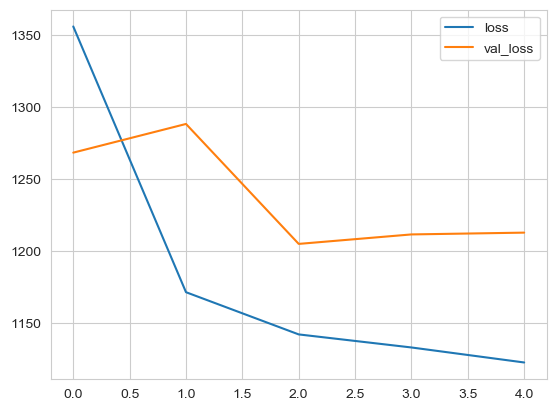

In [56]:
# plot loss metrics
ax1 = plt.plot(history.history["loss"])
ax2 = plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])


In [57]:
# Use model redict test set
y_pred = model.predict(X_test)
y_test = np.array(y_test)


Highest Risk Group(5.00% of total clients) can capture 16.73% of total revenue_loss


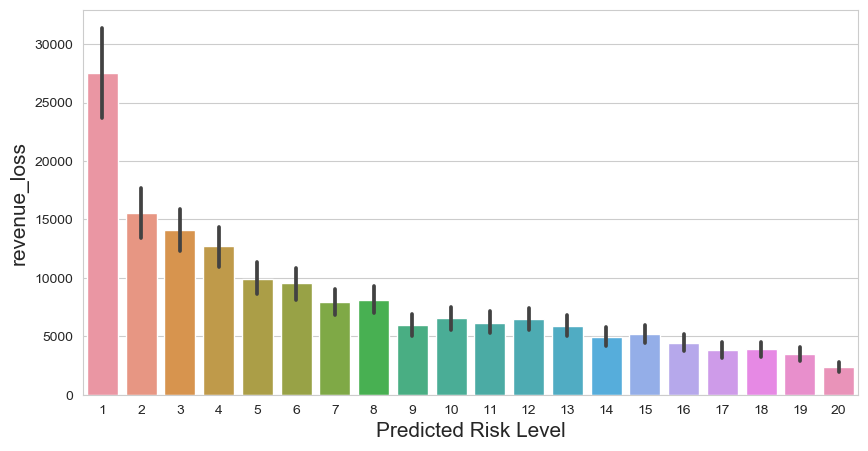

In [58]:
# Plot a chart of how many of total revenue loss can be captured with our predicted highest risk group
temp = X_test.copy()
temp["revenue_loss"] = y_test
temp["y_pred"] = y_pred
n = 20
temp["y_pred_bin"] = pd.qcut(temp["y_pred"], n, duplicates="drop")
l = len(temp["y_pred_bin"].unique())
labels = [l + 1 - i for i in range(1, l + 1)]
temp["y_pred_bin"] = pd.qcut(temp["y_pred"], n, labels=labels, duplicates="drop")
index_amount = temp.index[(temp.y_pred_bin == 1)]
fig = plt.figure(figsize=(10, 5))
labels.sort()
ax = sns.barplot(
    x="y_pred_bin", y="revenue_loss", data=temp, estimator=np.sum, order=labels
)
plt.xlabel("Predicted Risk Level", fontsize=15)
plt.ylabel("revenue_loss", fontsize=15)
per = 100 * sum(temp.y_pred_bin == 1) / len(temp.y_pred_bin)
print(
    "Highest Risk Group(%.2f%% of total clients) can capture %.2f%% of total revenue_loss"
    % (
        per,
        100 * temp[(temp.y_pred_bin == 1)].revenue_loss.sum() / temp.revenue_loss.sum(),
    )
)


## Customer Segmentation  <a name="Segmentation"></a>

In [59]:
# Trains a k-means model
kmeans = KMeans(featuresCol="scaledFeatures", k=4, initSteps=2, tol=0.0001, maxIter=20)
model = kmeans.fit(scaledData)


In [60]:
# Make predictions
predictions = model.transform(scaledData)


In [61]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))


Silhouette with squared euclidean distance = 0.007004465345663382


In [62]:
# Create a Pandas DataFrame for data visualization
cluster = predictions.toPandas()


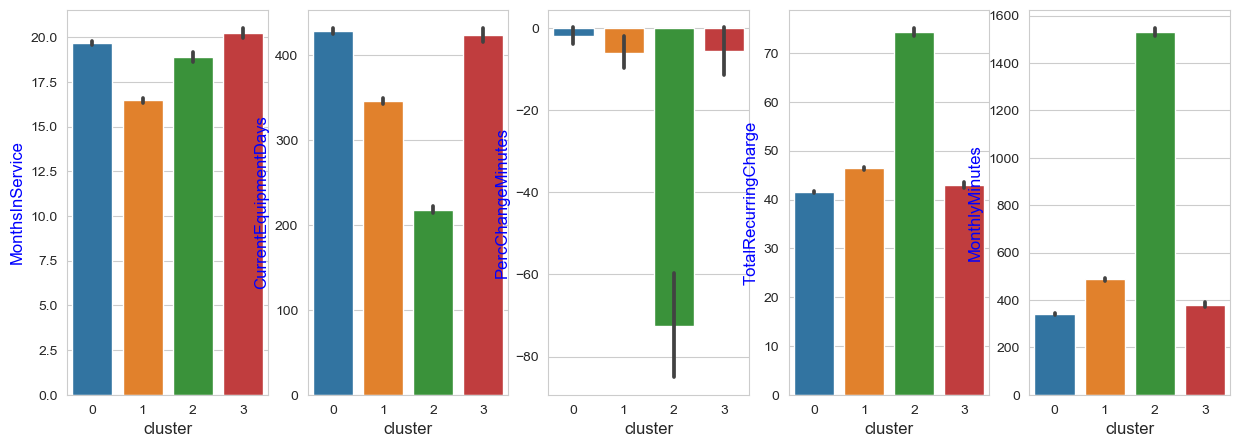

In [63]:
# Compare the different distributions of each cluster
temp_list = list(feature_importance.iloc[:5, 0])
temp_list.append("prediction")
temp = cluster.loc[:, temp_list]

fig, axs = plt.subplots(figsize=(15, 5), ncols=len(temp_list) - 1)

for i in range(len(temp_list) - 1):
    ax = sns.barplot(x="prediction", y=temp_list[i], data=temp, ax=axs[i])
    ax.set_xlabel("cluster", fontsize=12)
    ax.set_ylabel(temp_list[i], fontsize=12, color="blue")
